In [1]:
# 引用需要的library
import numpy as np
import helper
import joblib
import os
import jieba
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

import time
import warnings
warnings.filterwarnings('ignore')

c:\Users\gh\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# 从文本文件中读数据
# 读取到的内容
# X=评论（string）， y=情感分类（0/1）
folder_path = './user_comments'  # 请将此处替换为您的文件夹路径
# 使用CountVectorizer进行文本向量化
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()
# ont-hot
X, y = helper.Read_comments_from_file(folder_path=folder_path, vectorizer=vectorizer)
# X=稀疏矩阵（int），y=情感分类（0/1）

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\gh\AppData\Local\Temp\jieba.cache
Loading model cost 0.309 seconds.
Prefix dict has been built successfully.


In [3]:
X.shape, y.shape

((5999, 21309), (5999,))

In [4]:
# 数据集切分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
'''
    用函数的方式创建简单的参数搜索
'''
# 创建简单的超参数搜索
from itertools import product
def grid_search_simple(X_train, y_train, X_test, y_test, model, param_grid):
    best_score = -1
    best_params = None
    train_duration = None
    
    # Generate all combinations of hyperparameters
    param_combinations = product(*param_grid.values())
    
    # Perform grid search
    for params in param_combinations:
        # Convert params tuple to dictionary
        params_dict = dict(zip(param_grid.keys(), params))
        
        # Set model parameters
        model.set_params(**params_dict)
        
        # Time start
        start = time.perf_counter()

        # Train the model
        model.fit(X_train, y_train)
        
        # Time end
        end = time.perf_counter() 

        # Evaluate the model
        score = model.score(X_test, y_test)
        
        # Update best score and best parameters if needed
        if score > best_score:
            best_score = score
            best_params = params_dict
            train_duration = round(end - start, 2)
    
    return best_params, best_score, train_duration

In [8]:
'''
    用类的方式创建简单的参数搜索
    使用方法：
        - .fit 训练过程
        - .model_name 模型名称
        - .best_score 最佳分数
        - .best_params 最佳参数
        - .train_duration 训练时间
    使用说明：
        - 没有定义predict，后期需要可以添加，超参训练，直接用socre活得准确率
        - 定义这些方法，方便汇总所有模型最佳分数，画图分析对比
'''
class grid_search_test(object):

    def __init__(self, model, param_grid):

        self.model = model
        self.model_name = type(model).__name__
        self.param_grid = param_grid

        self.best_score = -1
        self.best_params = None
        self.train_duration = None

    def fit(self, X_train, y_train, X_test, y_test):

        # Generate all combinations of hyperparameters
        param_combinations = product(*self.param_grid.values()) 
        
        # Perform grid search
        for params in param_combinations:
            # Convert params tuple to dictionary
            params_dict = dict(zip(self.param_grid.keys(), params))
            
            # Set model parameters
            self.model.set_params(**params_dict)

            # Time start
            start = time.perf_counter()

            # Train the model
            self.model.fit(X_train, y_train)
            
            # Time end
            end = time.perf_counter() 

            # Evaluate the model
            score = self.model.score(X_test, y_test)
            
            # Update best score and best parameters if needed
            if score > self.best_score:
                self.best_score = score
                self.best_params = params_dict
                self.train_duration = round(end - start, 2)

        return self.best_score, self.best_params, self.train_duration
    
    def best_score(self):
        return self.best_score
    
    def best_params(self):
        return self.best_params
    
    def train_duration(self):
        return self.train_duration
    
    def model_name(self):
        return self.model_name

  
# # 举例说明用法
# # Define the model
# model = KNeighborsClassifier()

# # Define the hyperparameter grid
# param_grid = {
#     'n_neighbors': [5],  # 近邻数
#     'weights': ['uniform', 'distance'],  # 权重函数
# }

# # Perform grid search
# knn_gs = grid_search_test(model, param_grid)
# best_params, best_score, train_duration = knn_gs.fit(X_train, y_train, X_test, y_test)

# print(f'{knn_gs.model_name} best_score：{knn_gs.best_score}')
# print(f'{knn_gs.model_name} best_parameters：{knn_gs.best_params}')
# print(f'{knn_gs.model_name} train_duration：{knn_gs.train_duration}')

# # KNeighborsClassifier best_score：0.7766666666666666
# # KNeighborsClassifier best_parameters：{'n_neighbors': 5, 'weights': 'distance'}
# # KNeighborsClassifier train_duration：0.0


#### 1. LogisticRegression
- 关注的参数：
  - C：正则化强度的倒数。C 值越小，正则化强度越大。默认为 1.0。
  - penalty：正则化类型。可以选择 'l1'（L1 正则化）或 'l2'（L2 正则化）。默认为 'l2'。
  - max_iter：算法收敛的最大迭代次数。默认为 100。
  - solver：用于优化问题的算法。可以选择不同的求解器，如 'liblinear'、'lbfgs'、'newton-cg'、'sag' 和 'saga'。默认为 'lbfgs'。

In [6]:
'''
    随机搜索超参数
'''
from scipy.stats import uniform

# 定义LogisticRegression模型
log_reg = LogisticRegression()

# 定义要搜索的参数分布
param_dist = {
    'penalty': ['l1', 'l2'],  # 正则化类型
    'C': uniform(0.1, 10),  # 正则化强度的倒数的均匀分布
}

# 实例化RandomizedSearchCV对象
random_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)

# 使用随机搜索拟合数据
random_search.fit(X, y)

# 输出最佳参数组合和对应的得分
print("最佳参数组合：", random_search.best_params_)
print("最佳交叉验证得分：", random_search.best_score_)

最佳参数组合： {'C': 0.10778765841014329, 'penalty': 'l2'}
最佳交叉验证得分： 0.8593066444259104


In [39]:
'''
    自定义超参数方法搜索
'''
# Define the model
model = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],  # 正则化强度的倒数
}

# Perform grid search
best_params, best_score, train_duration = grid_search_simple(X_train, y_train, X_test, y_test, model, param_grid)

print("Best parameters:", best_params)
print("Best score:", best_score)
print("Train_duration:", train_duration)

Best parameters: {'C': 1}
Best score: 0.905
Train_duration: 5.77


In [9]:
'''
    自定义超参数类搜索
'''
# Define the model
model = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],  # 正则化强度的倒数
}

# Perform grid search
log_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = log_gs.fit(X_train, y_train, X_test, y_test)

print(f'{log_gs.model_name} best_score：{log_gs.best_score}')
print(f'{log_gs.model_name} best_parameters：{log_gs.best_params}')
print(f'{log_gs.model_name} train_duration：{log_gs.train_duration}')

LogisticRegression best_score：0.905
LogisticRegression best_parameters：{'C': 1}
LogisticRegression train_duration：5.85


-----------------------------------------------------------------------------------------------

#### 2. KNeighborsClassifier
- 关注的参数：
  - n_neighbors：近邻数，即要考虑的最近邻居的数量。默认为 5
  - weights：用于预测的权重函数。可以选择 'uniform'（所有邻居的权重相等）、'distance'（权重与距离的倒数成正比）或自定义权重函数。默认为 'uniform'。
  - algorithm：用于计算最近邻居的算法。可以选择 'auto'、'ball_tree'、'kd_tree' 或 'brute'。默认为 'auto'，会根据训练数据的数量和维度自动选择适合的算法。

In [36]:
# Define the model
model = KNeighborsClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # 近邻数
    'weights': ['uniform', 'distance'],  # 权重函数
}

# Perform grid search
best_params, best_score, train_duration = grid_search_simple(X_train, y_train, X_test, y_test, model, param_grid)

print("Best parameters:", best_params)
print("Best score:", best_score)
print("Train_duration:", train_duration)

Best parameters: {'n_neighbors': 11, 'weights': 'distance'}
Best score: 0.7816666666666666
Train_duration: 0.0


In [10]:
# Define the model
model = KNeighborsClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # 近邻数
    'weights': ['uniform', 'distance'],  # 权重函数
}

# Perform grid search
knn_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = knn_gs.fit(X_train, y_train, X_test, y_test)

print(f'{knn_gs.model_name} best_score：{knn_gs.best_score}')
print(f'{knn_gs.model_name} best_parameters：{knn_gs.best_params}')
print(f'{knn_gs.model_name} train_duration：{knn_gs.train_duration}')

KNeighborsClassifier best_score：0.7816666666666666
KNeighborsClassifier best_parameters：{'n_neighbors': 11, 'weights': 'distance'}
KNeighborsClassifier train_duration：0.0



- 交叉验证的分数没有遍历分数高，猜测的原因：数据稀疏性比较强，交叉验证分成很多子集，子集数据量比较小，导致训练出来的模型在测试集上的效果不好。
- --------------------------------------------------------------------------------------------------------------------------------------

#### 3. DecisionTreeClassifier
- 关注的参数：
  - criterion： 决策树的分裂标准，可选值为"gini"和"entropy"。
  - max_depth： 树的最大深度。控制树的最大深度可以防止过拟合。通常需要根据数据的复杂度来调整这个参数。
  - min_samples_split： 节点分裂所需的最小样本数。如果一个节点的样本数少于这个值，则不再分裂。增大这个值可以防止过拟合。
  - min_samples_leaf： 叶子节点所需的最小样本数。如果一个叶子节点的样本数少于这个值，则不再分裂。增大这个值可以防止过拟合。
  - max_features： 节点分裂时考虑的最大特征数。可以是整数（表示具体的特征数），也可以是浮点数（表示特征数的百分比）。默认为"None"，表示考虑所有特征。
  - max_leaf_nodes： 树的最大叶子节点数。如果指定了这个参数，则树会在达到指定数量的叶子节点后停止生长。
  - random_state： 随机数种子，用于控制随机性，保证结果的可重复性。


In [11]:
# 定义DecisionTreeClassifier模型
model = DecisionTreeClassifier()

# 定义要搜索的参数范围
param_grid = {
    'criterion': ['gini', 'entropy'],  # 根节点的划分方法
    'max_depth': [50, 100],  # 树的最大深度
    'random_state': [0, 1, 2, 3, 4],  # 随机数种子
}

# 实例化grid_search对象，并训练
dtc_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = dtc_gs.fit(X_train, y_train, X_test, y_test)

# 输出最佳参数组合和对应的得分
print(f'{dtc_gs.model_name} best_score：{dtc_gs.best_score}')
print(f'{dtc_gs.model_name} best_parameters：{dtc_gs.best_params}')
print(f'{dtc_gs.model_name} train_duration：{dtc_gs.train_duration}')

DecisionTreeClassifier best_score：0.8441666666666666
DecisionTreeClassifier best_parameters：{'criterion': 'entropy', 'max_depth': 100, 'random_state': 1}
DecisionTreeClassifier train_duration：5.9


- --------------------------------------------------------------------------------------------------------------------------------------

#### 4. RandomForestClassifier
- 关注的参数：
  - n_estimators: 树的个数，增加树的数量通常会提高模型的性能，但也会增加计算成本。可以通过交叉验证来选择合适的数量。  
  - criterion: 选择特征时的划分标准，可选值为"gini"和"entropy"。
  - max_depth: 树的最大深度。控制树的最大深度可以防止过拟合。通常需要根据数据的复杂度来调整这个参数。
  - min_samples_split: 节点分裂所需的最小样本数。如果一个节点的样本数少于这个值，则不再分裂。增大这个值可以防止过拟合
  - min_samples_leaf: 叶子节点所需的最小样本数。如果一个叶子节点的样本数少于这个值，则不再分裂。增大这个值可以防止过拟合
  - max_features: 最大特征数，默认为"auto"，表示考虑 sqrt(n_features) 个特征。
  - max_leaf_nodes: 叶子节点的最大个数。
  - min_impurity_decrease: 最小信息增益，增大这个值可以防止过拟合。
  - oob_score: 是否使用袋外数据进行验证，默认为False。袋外样本是在bootstrap采样中未被选中的样本，可以用来评估模型的泛化能力。

In [20]:
# 定义RandomForestClassifier模型
model = RandomForestClassifier()

# 定义要搜索的参数范围
param_grid = {
    'criterion': ['gini', 'entropy'],  # 根节点的划分方法
    'n_estimators': [50, 100, 200],  # 树的最大深度
}

# 实例化grid_search对象，并训练
rfc_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = rfc_gs.fit(X_train, y_train, X_test, y_test)

# 输出最佳参数组合和对应的得分
print(f'{rfc_gs.model_name} best_score：{rfc_gs.best_score}')
print(f'{rfc_gs.model_name} best_parameters：{rfc_gs.best_params}')
print(f'{rfc_gs.model_name} train_duration：{rfc_gs.train_duration}')

RandomForestClassifier best_score：0.9025
RandomForestClassifier best_parameters：{'criterion': 'gini', 'n_estimators': 100}
RandomForestClassifier train_duration：22.48


- RandomForestClassifier模型最佳参数组合：{'crierion': 'gini', 'n_estimators': 100}
- RandomForestClassifier模型最佳测试集准确率：0.9025
- --------------------------------------------------------------------------------------------------------------------------------------

#### 5. SVC
- 关注的参数：
    - C: 正则化参数，控制错误项的惩罚程度。C值越小，模型对错误项的容忍度越高，决策边界更平滑；C值越大，模型对错误项的容忍度越低，决策边界更严格。默认值为1.0。
    - kernel: 分类器使用的核函数，可选值为‘linear’、‘poly’、‘rbf’、‘sigmoid’。默认值为'rbf'。
    - degree: 多项式核函数的多项式次数，仅在kernel为'poly'时有效。默认为3.
    - gamma: 核函数的系数，影响核函数的宽度。gamma值越大，决策边界越不规则，模型对训练数据的拟合程度越高，可能导致过拟合；gamma值越小，决策边界越平滑，模型泛化能力可能更好。

In [15]:
kernel = ['rbf', 'linear']
C = [0.1, 1, 10]
gamma = [0.1, 1, 10]

for i in C:
    for j in kernel:
        for k in gamma:
            model = SVC(C=i, kernel=j, gamma=k, random_state=0)
            model.fit(X_train, y_train)
            print(f"C={i}, kernel={j}, gamma={k}, Accuracy: {model.score(X_test, y_test)}")

C=0.1, kernel=rbf, gamma=0.1, Accuracy: 0.615
C=0.1, kernel=rbf, gamma=1, Accuracy: 0.4925
C=0.1, kernel=rbf, gamma=10, Accuracy: 0.4925
C=0.1, kernel=linear, gamma=0.1, Accuracy: 0.89
C=0.1, kernel=linear, gamma=1, Accuracy: 0.89
C=0.1, kernel=linear, gamma=10, Accuracy: 0.89
C=1, kernel=rbf, gamma=0.1, Accuracy: 0.8216666666666667
C=1, kernel=rbf, gamma=1, Accuracy: 0.6975
C=1, kernel=rbf, gamma=10, Accuracy: 0.6966666666666667
C=1, kernel=linear, gamma=0.1, Accuracy: 0.8866666666666667
C=1, kernel=linear, gamma=1, Accuracy: 0.8866666666666667
C=1, kernel=linear, gamma=10, Accuracy: 0.8866666666666667
C=10, kernel=rbf, gamma=0.1, Accuracy: 0.8275
C=10, kernel=rbf, gamma=1, Accuracy: 0.6975
C=10, kernel=rbf, gamma=10, Accuracy: 0.6966666666666667
C=10, kernel=linear, gamma=0.1, Accuracy: 0.8808333333333334
C=10, kernel=linear, gamma=1, Accuracy: 0.8808333333333334
C=10, kernel=linear, gamma=10, Accuracy: 0.8808333333333334


In [15]:
# 定义SVC模型
model = SVC()

# 定义要搜索的参数范围
param_grid = {
    'kernel': ['linear'],  
    'C': [0.1, 1, 10]
}

# 实例化grid_search对象，并训练
svc_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = svc_gs.fit(X_train, y_train, X_test, y_test)

# 输出最佳参数组合和对应的得分
print(f'{svc_gs.model_name} best_score：{svc_gs.best_score}')
print(f'{svc_gs.model_name} best_parameters：{svc_gs.best_params}')
print(f'{svc_gs.model_name} train_duration：{svc_gs.train_duration}')

SVC best_score：0.89
SVC best_parameters：{'kernel': 'linear', 'C': 0.1}
SVC train_duration：49.97


- SVC模型最佳参数组合：{'kernel': 'linear', 'C': 0.1}
- SVC模型最佳测试集准确率：0.89
- --------------------------------------------------------------------------------------------------------------------------------------

#### 6. AdaBoostClassifier
- 关注的参数：
  - n_estimators: 弱学习器的数量（即迭代次数）。默认为50。增加n_estimators通常会提高模型的性能，但也会增加训练时间。
  - learning_rate: 默认为1。较小的学习率需要更多的弱学习器来达到相同的性能，但可能会提高模型的泛化能力。
  - algorithm: 用于计算加权错误率的算法。默认为“SAMME.R”。
  - base_estimator: 指定要使用的基础分类器，默认为DecisionTreeClassifier(max_depth=1)
  - random_state: 默认为None


In [35]:
# 定义AdaBoostClassifier模型
model = AdaBoostClassifier()

# 定义要搜索的参数范围
param_grid = {
    'n_estimators': [50, 100, 200],  # 弱学习器数量
    'learning_rate': [0.01, 0.1, 1.0],  # 学习率
}

# 实例化grid_search对象，并训练
best_params, best_score, train_duration = grid_search_simple(X_train, y_train, X_test, y_test, model, param_grid)

# 输出最佳参数组合和对应的得分
print("Best parameters:", best_params)
print("Best score:", best_score)
print("Train_duration:", train_duration)

Best parameters: {'n_estimators': 200, 'learning_rate': 1.0}
Best score: 0.8541666666666666
Train_duration: 250.53


In [22]:
# 定义AdaBoostClassifier模型
model = AdaBoostClassifier()

# 定义要搜索的参数范围
param_grid = {
    'n_estimators': [50, 100, 200],  # 弱学习器数量
    'learning_rate': [0.01, 0.1, 1.0],  # 学习率
}

# 实例化grid_search对象，并训练
ada_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = ada_gs.fit(X_train, y_train, X_test, y_test)

# 输出最佳参数组合和对应的得分
print(f'{ada_gs.model_name} best_score：{ada_gs.best_score}')
print(f'{ada_gs.model_name} best_parameters：{ada_gs.best_params}')
print(f'{ada_gs.model_name} train_duration：{ada_gs.train_duration}')

AdaBoostClassifier best_score：0.8541666666666666
AdaBoostClassifier best_parameters：{'n_estimators': 200, 'learning_rate': 1.0}
AdaBoostClassifier train_duration：255.15


- AdaBoostClassifier模型最佳参数组合：{'n_estimators': 200, 'learning_rate': 1.0}
- AdaBoostClassifier模型最佳测试集准确率：0.85416
- --------------------------------------------------------------------------------------------------------------------------------------

#### 7. GradientBoostingClassifier
- 关注的参数：
  - n_estimators: 树的个数。默认为100。
  - max_depth: 树的最大深度。默认为3。限制树的深度可以控制模型的复杂度，防止过拟合。
  - learning_rate: 学习率。默认为0.1。
  - loss：用于指定损失函数的类型。可以选择 'deviance'（对数损失函数，用于分类问题）或 'exponential'（指数损失函数，用于概率估计问题）。默认为'deviance'。
  

In [17]:
# 定义GradientBoostingClassifier模型
model = GradientBoostingClassifier()

# 定义要搜索的参数范围
param_grid = {
    'n_estimators': [50, 100, 200],  # 弱学习器数量
    'learning_rate': [0.01, 0.1, 1.0],  # 学习率
}

# 实例化grid_search对象，并训练
gbc_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = gbc_gs.fit(X_train, y_train, X_test, y_test)

# 输出最佳参数组合和对应的得分
print(f'{gbc_gs.model_name} best_score：{gbc_gs.best_score}')
print(f'{gbc_gs.model_name} best_parameters：{gbc_gs.best_params}')
print(f'{gbc_gs.model_name} train_duration：{gbc_gs.train_duration}')

GradientBoostingClassifier best_score：0.875
GradientBoostingClassifier best_parameters：{'n_estimators': 200, 'learning_rate': 1.0}
GradientBoostingClassifier train_duration：493.22


#### 8. XGBClassifier
- 关注的参数：
  - learning_rate：学习率，控制每个树的贡献。较小的学习率可以使模型更加保守，通常需要较多的迭代次数。默认为0.3。
  - n_estimators：要构建的树的数量（迭代次数）。默认为100。
  - max_depth：每棵树的最大深度。增加深度会增加模型的复杂度，有可能导致过拟合。默认为6。

In [18]:
# 定义XGBClassifier模型
model = XGBClassifier()

# 定义要搜索的参数范围
param_grid = {
    'n_estimators': [50, 100, 200],  # 弱学习器数量
    'learning_rate': [0.01, 0.1, 1.0],  # 学习率
}

# 实例化grid_search对象，并训练
xgb_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = xgb_gs.fit(X_train, y_train, X_test, y_test)

# 输出最佳参数组合和对应的得分
print(f'{xgb_gs.model_name} best_score：{xgb_gs.best_score}')
print(f'{xgb_gs.model_name} best_parameters：{xgb_gs.best_params}')
print(f'{xgb_gs.model_name} train_duration：{xgb_gs.train_duration}')

XGBClassifier best_score：0.8975
XGBClassifier best_parameters：{'n_estimators': 200, 'learning_rate': 1.0}
XGBClassifier train_duration：6.51


#### 9. LGBMClassifier
- 关注的参数：
  - n_estimators：要构建的树的数量（迭代次数）。默认为100。
  - learning_rate：学习率，控制每次迭代的步长。较小的学习率使得模型更加保守，但需要更多的迭代次数来收敛。默认为0.1。
  - max_depth：每棵树的最大深度。增加深度会增加模型的复杂度，有可能导致过拟合。默认为-1，表示没有限制。

In [19]:
# 定义LGBMClassifier模型
model = LGBMClassifier()

# 定义要搜索的参数范围
param_grid = {
    'n_estimators': [50, 100, 200],  # 弱学习器数量
    'learning_rate': [0.01, 0.1, 1.0],  # 学习率
}

# 实例化grid_search对象，并训练
lgb_gs = grid_search_test(model, param_grid)
best_params, best_score, train_duration = lgb_gs.fit(X_train, y_train, X_test, y_test)

# 输出最佳参数组合和对应的得分
print(f'{lgb_gs.model_name} best_score：{lgb_gs.best_score}')
print(f'{lgb_gs.model_name} best_parameters：{lgb_gs.best_params}')
print(f'{lgb_gs.model_name} train_duration：{lgb_gs.train_duration}')

[LightGBM] [Info] Number of positive: 2409, number of negative: 2390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4469
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 1307
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501980 -> initscore=0.007918
[LightGBM] [Info] Start training from score 0.007918
[LightGBM] [Info] Number of positive: 2409, number of negative: 2390
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4469
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 1307
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501980 -> initscore=0.007918
[LightG

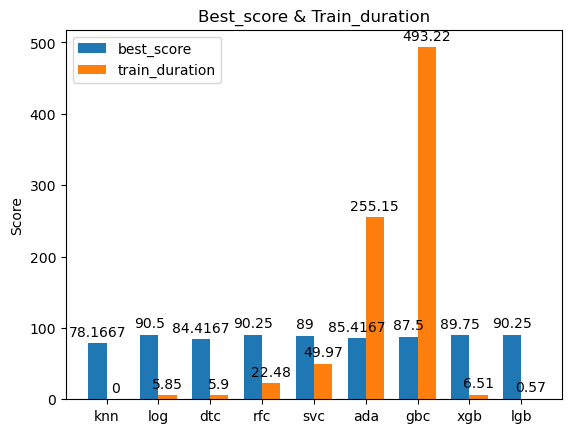

In [28]:
# 画图
labels = ['knn','log','dtc','rfc','svc','ada','gbc','xgb','lgb']
best_score = [knn_gs.best_score, log_gs.best_score, dtc_gs.best_score, rfc_gs.best_score, svc_gs.best_score, ada_gs.best_score, gbc_gs.best_score, xgb_gs.best_score, lgb_gs.best_score]
scores = [s * 100 for s in best_score]
train_duration = [knn_gs.train_duration, log_gs.train_duration, dtc_gs.train_duration, rfc_gs.train_duration, svc_gs.train_duration, ada_gs.train_duration, gbc_gs.train_duration, xgb_gs.train_duration, lgb_gs.train_duration] 
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, scores, width, label='best_score')
rects2 = ax.bar(x + width/2, train_duration, width, label='train_duration')

ax.set_ylabel('Score')
ax.set_title('Best_score & Train_duration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

In [26]:
# 各模型最优参数

print(f'{knn_gs.model_name} best_parameters：{knn_gs.best_params}')
print(f'{log_gs.model_name} best_parameters：{log_gs.best_params}')
print(f'{dtc_gs.model_name} best_parameters：{dtc_gs.best_params}')
print(f'{svc_gs.model_name} best_parameters：{svc_gs.best_params}')
print(f'{rfc_gs.model_name} best_parameters：{rfc_gs.best_params}')
print(f'{ada_gs.model_name} best_parameters：{ada_gs.best_params}')
print(f'{gbc_gs.model_name} best_parameters：{gbc_gs.best_params}')
print(f'{xgb_gs.model_name} best_parameters：{xgb_gs.best_params}')
print(f'{lgb_gs.model_name} best_parameters：{lgb_gs.best_params}')


KNeighborsClassifier best_parameters：{'n_neighbors': 11, 'weights': 'distance'}
LogisticRegression best_parameters：{'C': 1}
DecisionTreeClassifier best_parameters：{'criterion': 'entropy', 'max_depth': 100, 'random_state': 1}
SVC best_parameters：{'kernel': 'linear', 'C': 0.1}
RandomForestClassifier best_parameters：{'criterion': 'gini', 'n_estimators': 100}
AdaBoostClassifier best_parameters：{'n_estimators': 200, 'learning_rate': 1.0}
GradientBoostingClassifier best_parameters：{'n_estimators': 200, 'learning_rate': 1.0}
XGBClassifier best_parameters：{'n_estimators': 200, 'learning_rate': 1.0}
LGBMClassifier best_parameters：{'n_estimators': 200, 'learning_rate': 0.1}
